In [4]:
# ========================= Importar Librerias ======================================

import matplotlib.pyplot as plt
import thejoker.units as xu
import scipy.stats as stats
import astropy.units as u
import statistics as stat
import seaborn as sns
import thejoker as tj
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm
import warnings
warnings.filterwarnings('ignore')
import inspect
import corner
import math 
import h5py
import os


from astropy.visualization.units import quantity_support
from sklearn.metrics import mean_squared_error
from thejoker import JokerPrior, TheJoker, RVData
from thejoker.plot import plot_rv_curves
from scipy.stats import gaussian_kde
from os.path import join
from tqdm import tqdm

In [5]:
# ========================= Definición de Funciones ======================================
def seleccionar_distribuciones(familia='realall', verbose=True):
    '''
    Esta función selecciona un subconjunto de las distribuciones disponibles
    en scipy.stats
    
    Parameters
    ----------
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
        
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    distribuciones: list
        listado con las distribuciones (los objetos) seleccionados.
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----
        Las distribuciones levy_stable y vonmises han sido excluidas por el momento.

    '''
    
    distribuciones = [getattr(stats,d) for d in dir(stats) \
                     if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
    
    exclusiones = ['levy_stable', 'vonmises']
    distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
            
    dominios = {
        'realall' : [-np.inf, np.inf],
        'realline': [np.inf,np.inf],
        'realplus': [0, np.inf],
        'real0to1': [0, 1], 
        'discreta': [None, None],
    }

    distribucion = []
    tipo = []
    dominio_inf = []
    dominio_sup = []

    for dist in distribuciones:
        distribucion.append(dist.name)
        tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
        dominio_inf.append(dist.a)
        dominio_sup.append(dist.b)
    
    info_distribuciones = pd.DataFrame({
                            'distribucion': distribucion,
                            'tipo': tipo,
                            'dominio_inf': dominio_inf,
                            'dominio_sup': dominio_sup
                          })

    info_distribuciones = info_distribuciones \
                          .sort_values(by=['dominio_inf', 'dominio_sup'])\
                          .reset_index(drop=True)
    
    if familia in ['realall', 'realline', 'realplus', 'real0to1']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
        condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                    (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
        info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
        
    if familia in ['discreta']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
        
    seleccion = [dist for dist in distribuciones \
                 if dist.name in info_distribuciones['distribucion'].values]
    
    
    if verbose:
        print("---------------------------------------------------")
        print("       Distribuciones seleccionadas                ")
        print("---------------------------------------------------")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
            print(info_distribuciones)
    
    return seleccion


def comparar_distribuciones(x, familia='realall', ordenar='aic', verbose=True):
    '''
    Esta función selecciona y ajusta un subconjunto de las distribuciones 
    disponibles en scipy.stats. Para cada distribución calcula los valores de
    Log Likelihood, AIC y BIC.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
    
    ordenar : {'aic', 'bic'}
        criterio de ordenación de mejor a peor ajuste.
    
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    resultados: data.frame
        distribucion: nombre de la distribución.
        log_likelihood: logaritmo del likelihood del ajuste.
        aic: métrica AIC.
        bic: métrica BIC.
        n_parametros: número de parámetros de la distribución de la distribución.
        parametros: parámetros del tras el ajuste
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----

    '''
    
    distribuciones = seleccionar_distribuciones(familia=familia, verbose=verbose)
    distribucion_ = []
    log_likelihood_= []
    aic_ = []
    bic_ = []
    n_parametros_ = []
    parametros_ = []
    
    for i, distribucion in enumerate(distribuciones):
        
        print(f"{i+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
        
        try:
            parametros = distribucion.fit(data=x)
            nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                 if not p=='x'] + ["loc","scale"]
            parametros_dict = dict(zip(nombre_parametros, parametros))
            log_likelihood = distribucion.logpdf(x, *parametros).sum()
            aic = -2 * log_likelihood + 2 * len(parametros)
            bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
            
            distribucion_.append(distribucion.name)
            log_likelihood_.append(log_likelihood)
            aic_.append(aic)
            bic_.append(bic)
            n_parametros_.append(len(parametros))
            parametros_.append(parametros_dict)
            
            resultados = pd.DataFrame({
                            'distribucion': distribucion_,
                            'log_likelihood': log_likelihood_,
                            'aic': aic_,
                            'bic': bic_,
                            'n_parametros': n_parametros_,
                            'parametros': parametros_,
                
                         })
            
            resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)
            
        except Exception as e:
            print(f"Error al tratar de ajustar la distribución {distribucion.name}")
            print(e)
            print("")
            
    return resultados

In [6]:
def plot_distribucion(x, nombre_distribucion, bin, label, unit, ax=None):
    '''
    Esta función superpone la curva de densidad de una distribución con el
    histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : str
        nombre de una de las distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''

    distribucion = getattr(stats, nombre_distribucion)

    parametros = distribucion.fit(data=x)

    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                         if not p=='x'] + ["loc","scale"]
    parametros_dict = dict(zip(nombre_parametros, parametros))

    log_likelihood = distribucion.logpdf(x, *parametros).sum()

    aic = -2 * log_likelihood + 2 * len(parametros)
    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

    x_hat = np.linspace(min(x), max(x), num=100)
    y_hat = distribucion.pdf(x_hat, *parametros)
    P_max = x_hat[np.argmax(y_hat)]
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    ax.hist(x=x, density=True, bins=bin, color="#3182bd", alpha=0.5,edgecolor = '#3F4750');
    ax.plot(x, np.full_like(x, 0), '|k', markeredgewidth=1)
    plt.axvline(P_max, color='#E74C3C', linestyle='--', label=f'Máximo en {label} = {P_max:.5f} {unit}')
    ax.set_title('Ajuste distribución')
    ax.set_xlabel(f'{label} [{unit}]')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

    print('---------------------')
    print('Resultados del ajuste')
    print('---------------------')
    print(f"Distribución:   {distribucion.name}")
    print(f"Dominio:        {[distribucion.a, distribucion.b]}")
    print(f"Parámetros:     {parametros_dict}")
    print(f"Log likelihood: {log_likelihood}")
    print(f"AIC:            {aic}")
    print(f"BIC:            {bic}")
    print(f"{label}_max:          {P_max} {unit}")
    return ax


def plot_multiple_distribuciones(x, nombre_distribuciones, bin, label, unit, ax=None):
    '''
    Esta función superpone las curvas de densidad de varias distribuciones
    con el histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : list
        lista con nombres de distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''
    aic_list = []
    bic_list = []
    nombres = []
    Best_fit = pd.DataFrame()
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.hist(x=x, density=True, bins=bin, color="#3182bd", alpha=0.5,edgecolor = '#3F4750')
    ax.plot(x, np.full_like(x, 0), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribuciones')
    ax.set_xlabel(f'{label} [{unit}]')
    ax.set_ylabel('Densidad de probabilidad')
    
    for nombre in nombre_distribuciones:
        
        distribucion = getattr(stats, nombre)

        parametros = distribucion.fit(data=x)

        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                             if not p=='x'] + ["loc","scale"]
        parametros_dict = dict(zip(nombre_parametros, parametros))

        log_likelihood = distribucion.logpdf(x, *parametros).sum()

        aic = -2 * log_likelihood + 2 * len(parametros)
        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
        aic_list.append(aic)
        bic_list.append(bic)
        nombres.append(distribucion.name)
        
        x_hat = np.linspace(min(x), max(x), num=100)
        y_hat = distribucion.pdf(x_hat, *parametros)
        ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
        
    ax.legend();
    
    Best_fit["Distribución"] = nombres
    Best_fit["AIC"] = aic_list
    Best_fit["BIC"] = bic_list
    Best_fit = Best_fit.sort_values(by='BIC')
    return ax, Best_fit

In [7]:
# Lee el archivo de texto y crea un DataFrame
nombres_columnas = ['Estrella', 'TYC', '2MASS']
data = pd.read_csv('Nombres_de_Estrellas.txt', delimiter=' ', names=nombres_columnas, header=None)  # Si el archivo está tabulado, usa '\t' como separador
data

,Estrella,TYC,2MASS
0,Krich_1,TYC22-591-1,2MASSJ01030596+0434459
1,Krich_2,TYC26-777-1,2MASSJ01194936+0634115
2,Na_rich,TYC6908-1643-1,2MASSJ20320320-2332524
3,Nrich_1,TYC4686-2039-1,2MASSJ01575297-0316508
4,Nrich_2,TYC8517-1671-1,2MASSJ05120630-5913438
5,Nrich_3,TYC244-273-1,2MASSJ10022398+0216045
6,Nrich_4,TYC250-1352-1,2MASSJ10071742+0605101
7,Nrich_5,TYC269-474-1,2MASSJ11173689+0645217
8,Nrich_6,TYC7408-694-1,2MASSJ18461977-3021506
9,Nrich_7,TYC5256-183-1,2MASSJ23513172-0312308


In [8]:
columns = ["Star","Date","RV","err_RV","S/R"]
Estrella = {}
mean = []
range = []
std = []
for i in data["Estrella"]:
    Estrella[i] = pd.read_csv(i+'.dat', delimiter='\t', names=columns, header=None)
    #print(Estrella[i])
    mean.append(np.mean(Estrella[i]["RV"]))
    range.append(np.max(Estrella[i]["RV"])-np.min(Estrella[i]["RV"]))
    std.append(np.std(Estrella[i]["RV"]))

In [9]:
Estrella["s-rich"]

,Star,Date,RV,err_RV,S/R
0,TYC6524-876-1,2.459617e+06,315.6384,0.0130,63
1,TYC6524-876-1,2.459651e+06,315.5357,0.0098,102
2,TYC6524-876-1,2.459657e+06,315.5778,0.0114,102
3,TYC6524-876-1,2.459658e+06,315.5968,0.0136,80
4,TYC6524-876-1,2.459659e+06,315.5781,0.0091,114
5,TYC6524-876-1,2.459662e+06,315.5318,0.0120,80
6,TYC6524-876-1,2.459665e+06,315.5052,0.0102,106
7,TYC6524-876-1,2.459667e+06,315.5417,0.0118,97


<Axes: xlabel='time [BMJD]', ylabel='RV [$\\mathrm{km\\,s^{-1}}$]'>

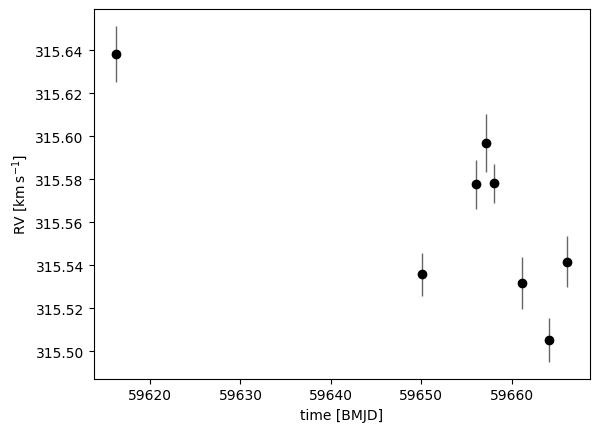

In [10]:
t = np.array(Estrella["s-rich"]["Date"])-2400000.5
rv = np.array(Estrella["s-rich"]["RV"]) * u.km/u.s
err = np.array(Estrella["s-rich"]["err_RV"]) * u.km/u.s
data = tj.RVData(t=t, rv=rv, rv_err=err)
data.plot()

In [11]:
np.std(rv)

<Quantity 0.03998067 km / s>

In [10]:
# data = RVData(t=t, rv=rv, rv_err=err)
# prior = JokerPrior.default(P_min=12.25*u.day, P_max=12.35*u.day,sigma_K0= 30*u.km/u.s,sigma_v=100*u.km/u.s)
# print("Listo")

In [11]:
# with pm.Model() as model:
#     P = xu.with_unit(pm.Normal("P", 762, 5), u.day)
#     K = xu.with_unit(pm.Normal("K", 25, 5), u.km / u.s)
#     prior = tj.JokerPrior.default(sigma_v=50 * u.km / u.s, pars={"P": P,"K" : K})
# joker = TheJoker(prior)

In [12]:
# rng = np.random.default_rng(seed=42) # pequeño retraso en el tiempo 
# prior_samples = prior.sample(size=1_500_000, rng=rng)

# print("Listo")

In [13]:
# prior_samples.write("prior_samples_Nrich7_newdata.hdf5", overwrite=True)

In [16]:
# samples = joker.rejection_sample(data,prior_samples, max_posterior_samples=1000)
# samples = samples.wrap_K()


In [17]:
# samples.write("samples_Nrich7_newdata.hdf5", overwrite=True)

In [18]:
samples = tj.JokerSamples.read("TJ_samples_srich_1.hdf5")
#samples_all = tj.JokerSamples.read("samples_Nrich7_all.hdf5")

samples

<JokerSamples [P, e, omega, M0, s, K, v0] (114 samples)>

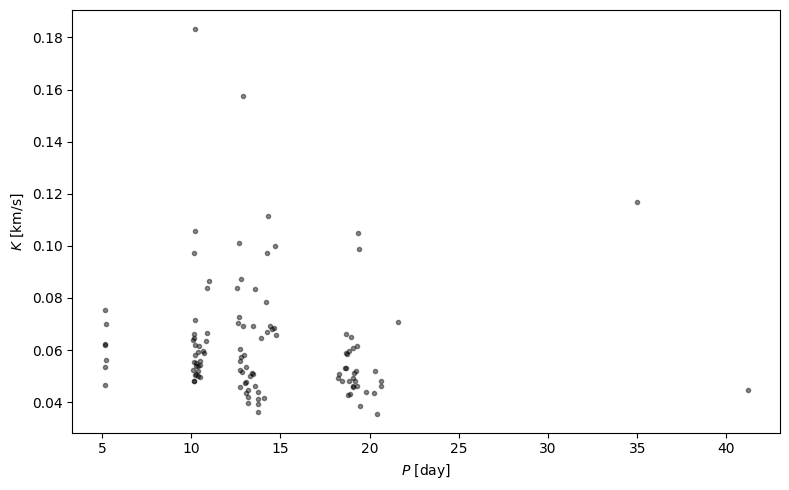

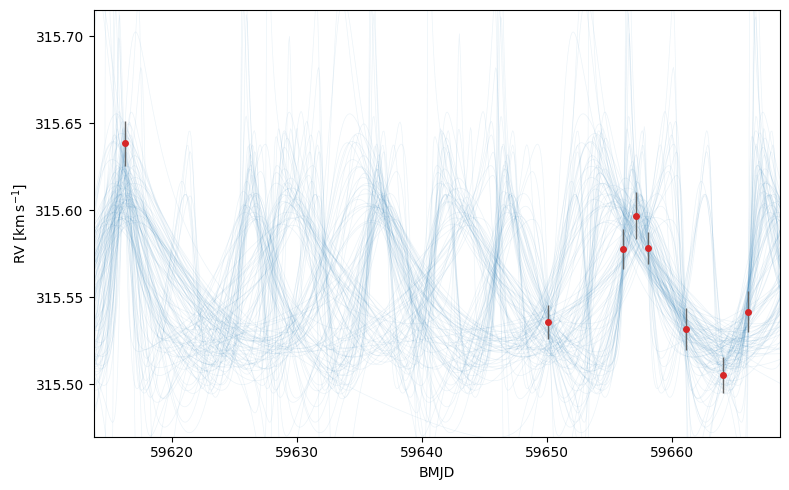

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="tight")
ax.scatter(samples['P'].value, samples['K'].to(u.km/u.s).value,marker='.', color='k', alpha=0.45)
#ax.set_ylim(0,20)
#plt.vlines(30.38,0,100)
ax.set_xlabel("$P$ [day]")
ax.set_ylabel("$K$ [km/s]")
fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="tight")


_ = tj.plot_rv_curves(samples,data=data,plot_kwargs=dict(color="tab:blue"),data_plot_kwargs=dict(color="tab:red"),relative_to_t_ref=False,ax=ax)



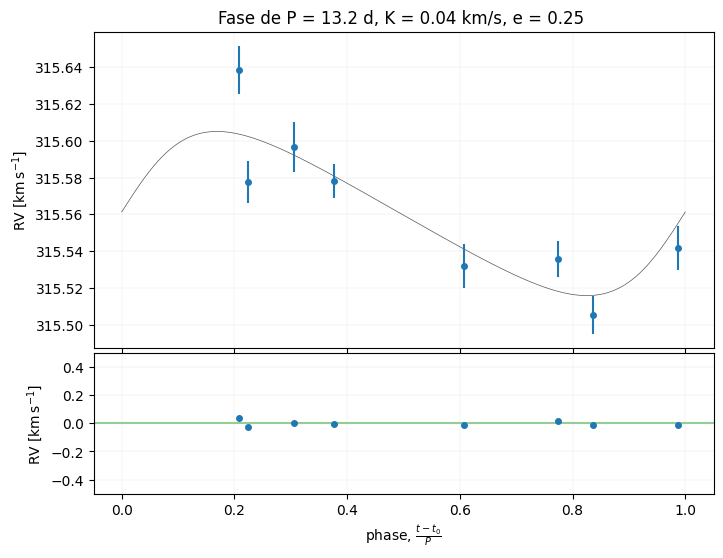

In [32]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={"height_ratios": (1.8, 0.8), 'hspace': 0.02})

ax[0].set_title(f"Fase de P = {round(float(samples.median_period()['P'].value),2)} d, K = {round(float(samples.median_period()['K'].value),2)} km/s, e = {round(float(samples.median_period()['e'].value),2)} ")

    
_ = tj.plot_phase_fold(samples.median_period(),data=data,ax=ax[0],remove_trend = False)
_ = tj.plot_phase_fold(samples.median_period(), data, ax=ax[1], residual=True)

ax[1].axhline(0, zorder=-10, color="tab:green", alpha=0.5)
ax[1].set_ylim(-0.5, 0.5)
for ax in fig.get_axes():
    ax.label_outer()
    ax.grid(linestyle='-', linewidth=0.1)

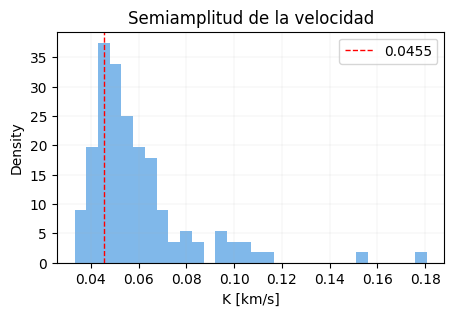

El pico más alto está en el valor: 0.04546013722274112


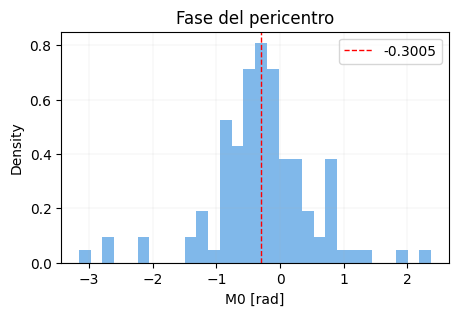

El pico más alto está en el valor: -0.300452675339582


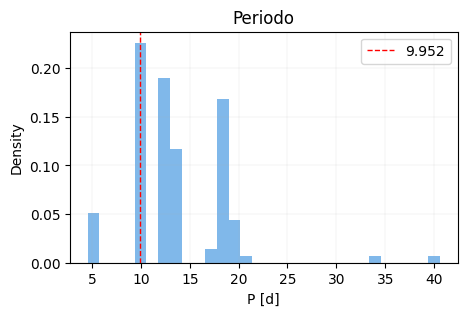

El pico más alto está en el valor: 9.951965030376691


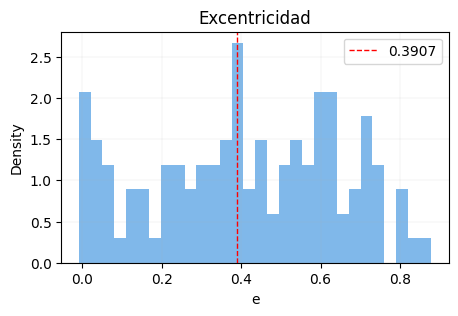

El pico más alto está en el valor: 0.3906639816089745


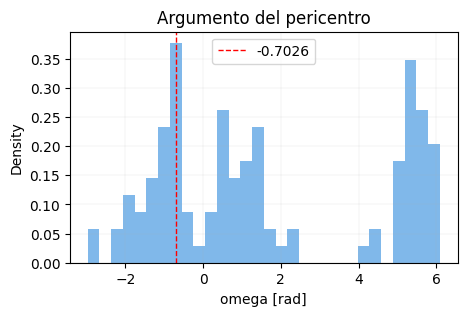

El pico más alto está en el valor: -0.7025842126055735


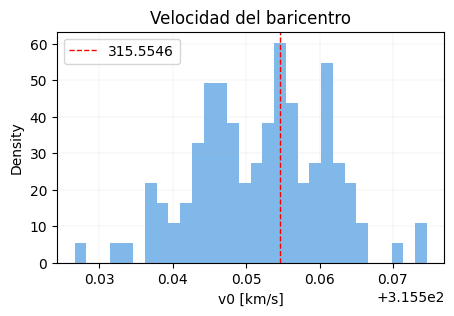

El pico más alto está en el valor: 315.55461263241193


In [33]:
variables = ["K","M0","P","e","omega","v0"]
xlabel = ["K [km/s]","M0 [rad]","P [d]","e","omega [rad]","v0 [km/s]"]
title = ["Semiamplitud de la velocidad","Fase del pericentro","Periodo","Excentricidad","Argumento del pericentro","Velocidad del baricentro"]
picos = []

for i in np.arange(len(variables)):
    plt.figure(figsize=(5,3))
    plt.ylabel("Density")
    plt.xlabel(xlabel[i])
    plt.title(title[i])
    conteos, bins, _  =  plt.hist(samples[variables[i]], bins = 30 ,density = True ,alpha=0.7, align = 'left', color = '#4B9BE2')
    
    plt.grid(linestyle='-', linewidth=0.1)
    
    # Encontrar el índice del valor máximo en los conteos
    indice_maximo = np.argmax(conteos)
    
    # Obtener el valor del pico más alto
    pico_mas_alto = bins[indice_maximo]
    picos.append(bins[indice_maximo])
    # Agregar una línea vertical en el pico más alto
    plt.axvline(x=pico_mas_alto, color='red', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,4)}")
    
    
    # Mostrar el histograma con el pico más alto resaltado
    plt.legend()
    plt.show()
    
    print("El pico más alto está en el valor:", pico_mas_alto)


In [20]:
# Ajuste y comparación de distribuciones
# ==============================================================================
resultados = comparar_distribuciones(
                x=samples["P"],
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados

1/32 Ajustando distribución: cauchy
2/32 Ajustando distribución: crystalball
3/32 Ajustando distribución: dgamma
4/32 Ajustando distribución: dweibull
5/32 Ajustando distribución: exponnorm
6/32 Ajustando distribución: genextreme
7/32 Ajustando distribución: genhyperbolic
8/32 Ajustando distribución: genlogistic
9/32 Ajustando distribución: gennorm
10/32 Ajustando distribución: gumbel_l
11/32 Ajustando distribución: gumbel_r
12/32 Ajustando distribución: hypsecant
13/32 Ajustando distribución: johnsonsu
14/32 Ajustando distribución: kappa4
15/32 Ajustando distribución: laplace
16/32 Ajustando distribución: laplace_asymmetric
17/32 Ajustando distribución: loggamma
18/32 Ajustando distribución: logistic
19/32 Ajustando distribución: loguniform
20/32 Ajustando distribución: moyal
21/32 Ajustando distribución: nct
22/32 Ajustando distribución: norm
23/32 Ajustando distribución: norminvgauss
24/32 Ajustando distribución: pearson3
25/32 Ajustando distribución: powernorm
26/32 Ajustando distr

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,powernorm,3479.669553,-6953.339106,-6938.615840,3,"{'c': 0.008389771419802999, 'loc': 12.28866598..."
1,genextreme,3472.439399,-6938.878799,-6924.155533,3,"{'c': 0.1393693015014127, 'loc': 12.2998219417..."
2,skewnorm,3471.571383,-6937.142766,-6922.419500,3,"{'a': 2.8170261754156973, 'loc': 12.2940386422..."
3,genhyperbolic,3473.178291,-6936.356582,-6911.817806,5,"{'p': 8.713713169731147, 'a': 0.66311369585269..."
4,norminvgauss,3471.244684,-6934.489367,-6914.858346,4,"{'a': 83.61761084709383, 'b': 81.245292625481,..."
5,johnsonsu,3470.415876,-6932.831753,-6913.200732,4,"{'a': -12.074324875588438, 'b': 4.756964426277..."
6,pearson3,3463.518255,-6921.036509,-6906.313244,3,"{'skew': 1.000000134200822, 'loc': 12.30300438..."
7,genlogistic,3460.897546,-6915.795092,-6901.071826,3,"{'c': 7.327052826495164, 'loc': 12.28771219868..."
8,gumbel_r,3459.070564,-6914.141128,-6904.325617,2,"{'loc': 12.299317516672435, 'scale': 0.0066420..."
9,exponnorm,3458.467274,-6910.934548,-6896.211282,3,"{'K': 0.872515263277208, 'loc': 12.29786677100..."


---------------------
Resultados del ajuste
---------------------
Distribución:   powernorm
Dominio:        [-inf, inf]
Parámetros:     {'c': 0.008389771419802999, 'loc': 12.288665985026991, 'scale': 0.001068943213397963}
Log likelihood: 3479.669552870082
AIC:            -6953.339105740164
BIC:            -6938.615839903217
P_max:          12.300128485400375 d


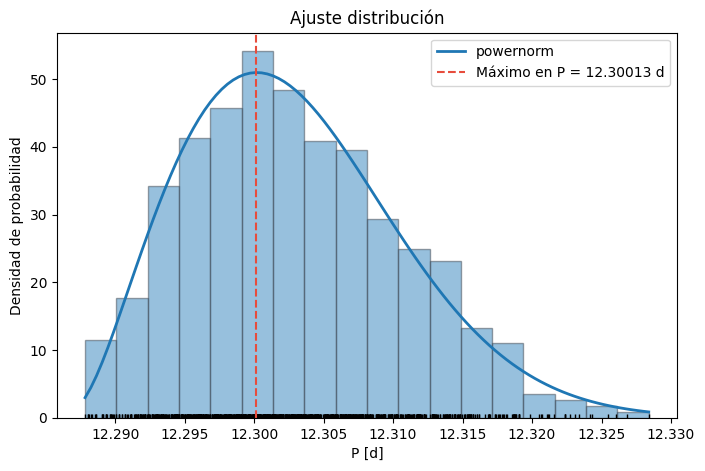

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
plot_distribucion(
    x=samples["P"].value,
    nombre_distribucion=resultados['distribucion'][0],
    bin = 18,
    label = "P",
    unit = "d",
    ax=ax
);

In [40]:
# Ajuste y comparación de distribuciones
# ==============================================================================
resultados_K = comparar_distribuciones(
                x=samples["K"],
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados_K

1/32 Ajustando distribución: cauchy
2/32 Ajustando distribución: crystalball
3/32 Ajustando distribución: dgamma
4/32 Ajustando distribución: dweibull
5/32 Ajustando distribución: exponnorm
6/32 Ajustando distribución: genextreme
7/32 Ajustando distribución: genhyperbolic
8/32 Ajustando distribución: genlogistic
9/32 Ajustando distribución: gennorm
10/32 Ajustando distribución: gumbel_l
11/32 Ajustando distribución: gumbel_r
12/32 Ajustando distribución: hypsecant
13/32 Ajustando distribución: johnsonsu
14/32 Ajustando distribución: kappa4
15/32 Ajustando distribución: laplace
16/32 Ajustando distribución: laplace_asymmetric
17/32 Ajustando distribución: loggamma
18/32 Ajustando distribución: logistic
19/32 Ajustando distribución: loguniform
20/32 Ajustando distribución: moyal
21/32 Ajustando distribución: nct
22/32 Ajustando distribución: norm
23/32 Ajustando distribución: norminvgauss
24/32 Ajustando distribución: pearson3
25/32 Ajustando distribución: powernorm
26/32 Ajustando distr

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,exponnorm,2901.107729,-5796.215459,-5781.492193,3,"{'K': 0.7350520770764124, 'loc': 0.20693114214..."
1,johnsonsu,2900.858718,-5793.717436,-5774.086415,4,"{'a': -1.4679594877559783, 'b': 3.329844968209..."
2,norminvgauss,2900.643524,-5793.287048,-5773.656026,4,"{'a': 8.588607903515502, 'b': 3.23843433443066..."
3,genhyperbolic,2900.965352,-5791.930704,-5767.391927,5,"{'p': -15.324250155373306, 'a': 10.66850371327..."
4,genlogistic,2898.557998,-5791.115995,-5776.392730,3,"{'c': 1.8831981797571, 'loc': 0.20668799077267..."
5,pearson3,2898.131983,-5790.263966,-5775.540700,3,"{'skew': 0.3355027416055403, 'loc': 0.21491390..."
6,skewnorm,2897.965381,-5789.930763,-5775.207497,3,"{'a': 1.6399856004612419, 'loc': 0.20240042952..."
7,powernorm,2895.290848,-5784.581695,-5769.858429,3,"{'c': 0.2261775056764304, 'loc': 0.20071095385..."
8,t,2893.037131,-5780.074263,-5765.350997,3,"{'df': 13.236051031459278, 'loc': 0.2146270737..."
9,tukeylambda,2891.045944,-5776.091888,-5761.368623,3,"{'lam': 0.041013073107460774, 'loc': 0.2145907..."


---------------------
Resultados del ajuste
---------------------
Distribución:   exponnorm
Dominio:        [-inf, inf]
Parámetros:     {'K': 0.7350520770764124, 'loc': 0.20693114214319058, 'scale': 0.010860559054746774}
Log likelihood: 2901.107729440203
AIC:            -5796.215458880406
BIC:            -5781.492193043459
K_max:          0.21325325574257797 km/s


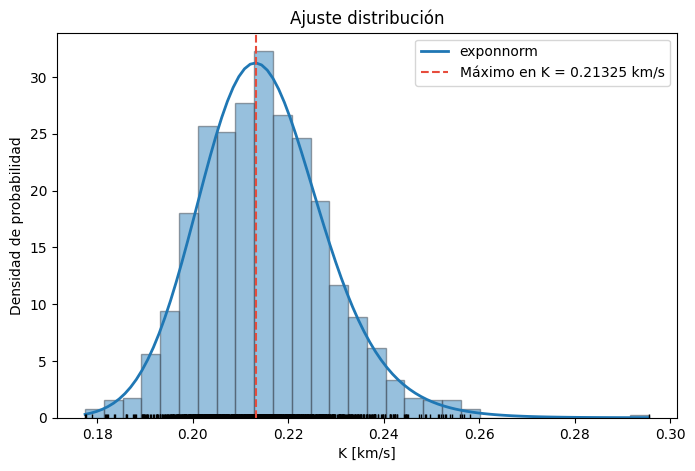

In [43]:
fig, ax = plt.subplots(figsize=(8,5))

plot_distribucion(
    x=samples["K"].value,
    nombre_distribucion=resultados_K['distribucion'][0],
    bin = 30,
    label = "K",
    unit = "km/s",
    ax=ax
);

In [22]:
# # Crear un gráfico de correlación utilizando pairplot
# df = samples.tbl.to_pandas()
# g = sns.PairGrid(df, 
#             x_vars=["K", "M0", "P", "e", "omega", "v0"],
#             y_vars=["K", "M0", "P", "e", "omega", "v0"],
#             #plot_kws=dict(marker=".", linewidth=1),        # Edito los scatter
#             #diag_kws=dict(fill=False),                     # Edito los histogramas
#             corner=True)                                   # No muestra las de encima de la diagonal
# # Mostrar el gráfico

# g.map_diag(plt.hist,  bins = 100 ,density = False ,alpha=0.7, align = 'left', color = '#4B9BE2',edgecolor = '#3F4750')             #Histogramas en la diagonal
# g.map_lower(sns.kdeplot,linewidths = 1, levels=6,  color="#3F4750",thresh=.1)             # Muestra los contornos
# g.map_lower(sns.scatterplot,s = 8, color="#4B9BE2")                     # Muestra los puntos

# # Añadir bordes y rejillas a cada cuadrícula
# for ax in g.axes.flatten():
#     if ax is not None:
#         ax.spines['left'].set_visible(True)
#         ax.spines['bottom'].set_visible(True)
#         ax.spines['right'].set_visible(True)
#         ax.spines['top'].set_visible(True)
#         ax.grid(False)
        
# # Agregar líneas verticales personalizadas en las diagonales
# for i in np.arange(len(g.diag_axes)):
#     ax = g.diag_axes[i]
#     ax.axvline(x=picos[i], color='red', linestyle='--',linewidth = 1, label = f"{round(picos[i],4)}")
#     ax.legend()
# # Título del PairGrid
# g.fig.suptitle("PairGrid of all dataset", y=1.02)

Text(0.5, 1.02, 'PairGrid of all dataset')

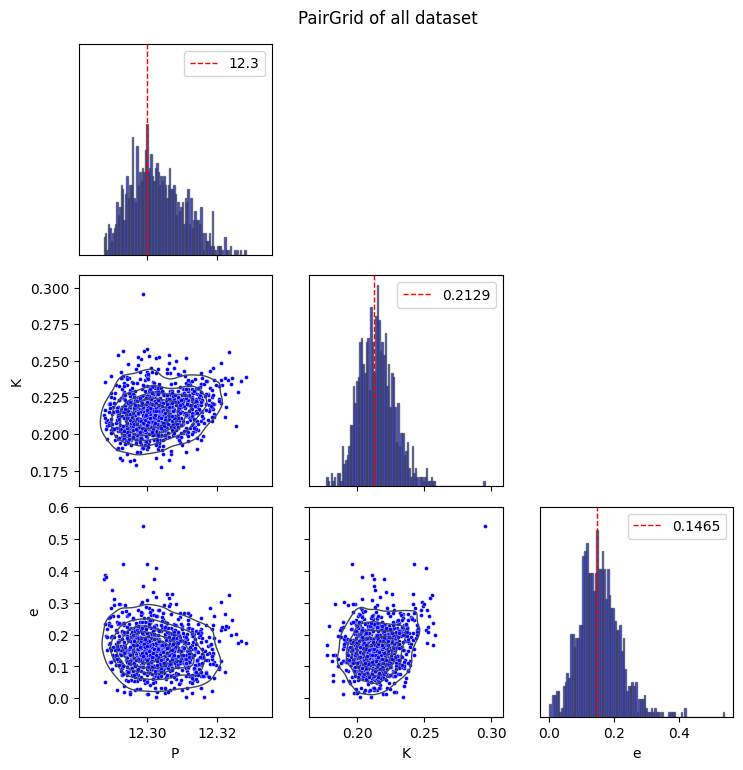

In [23]:
# Crear un gráfico de correlación utilizando pairplot
df = samples.tbl.to_pandas()
g = sns.PairGrid(df, 
            x_vars=["P","K", "e"],
            y_vars=["P","K", "e"],
            #plot_kws=dict(marker=".", linewidth=1),        # Edito los scatter
            #diag_kws=dict(fill=False),                     # Edito los histogramas
            corner=True)                                   # No muestra las de encima de la diagonal
# Mostrar el gráfico

g.map_diag(plt.hist,  bins = 100 ,density = False ,alpha=0.7, align = 'left', color = 'b',edgecolor = '#3F4750')             #Histogramas en la diagonal
g.map_lower(sns.kdeplot,linewidths = 1, levels=6,  color="#3F4750",thresh=.1)             # Muestra los contornos
g.map_lower(sns.scatterplot,s = 8, color="b")                     # Muestra los puntos

# Añadir bordes y rejillas a cada cuadrícula
for ax in g.axes.flatten():
    if ax is not None:
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.grid(False)
        
# Agregar líneas verticales personalizadas en las diagonales
pke = picos[2],picos[0],picos[3]
for i in np.arange(len(g.diag_axes)):
    ax = g.diag_axes[i]
    ax.axvline(x=pke[i], color='red', linestyle='--',linewidth = 1, label = f"{round(pke[i],4)}")
    ax.legend()
# Título del PairGrid
g.fig.suptitle("PairGrid of all dataset", y=1.02)

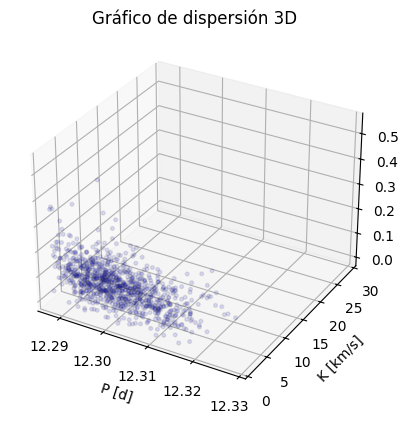

In [24]:
# Datos de muestra
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

ax.set_xlabel("P [d]")
ax.set_ylabel("K [km/s]")
ax.set_zlabel("e")
ax.set_ylim(0,30)
plt.title("Gráfico de dispersión 3D")

# Gráfico de dispersión 3D
ax.scatter(samples["P"], samples["K"], samples["e"],marker="o", s=7, color = "b", alpha=0.12, ec='#212325')

plt.show()

In [25]:
picos

[0.2128955800175093,
 -2.5119915813593368,
 12.300005575833694,
 0.1465044704730528,
 2.6703482079818963,
 -70.4341493341879]

In [26]:
P31 = samples[samples["K"].value<=4]

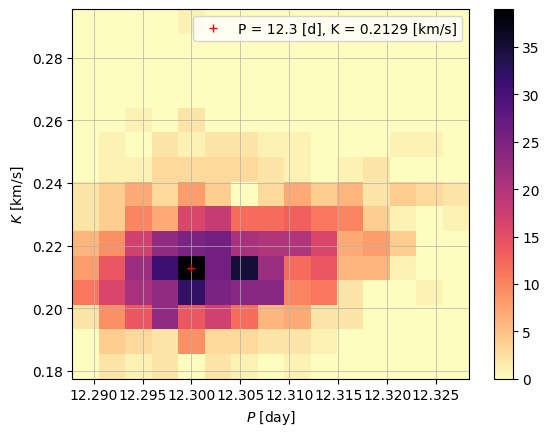

Coordenadas del valor más significativo:
x = 12.300005575833694
y = 0.2128955800175093


In [27]:
bin=15

# Calcula el histograma bidimensional
hist, x_edges, y_edges = np.histogram2d(x=P31['P'].value, y=P31['K'].to(u.km/u.s).value, bins=bin)

# Encuentra las coordenadas del bin con el valor máximo en el histograma
max_index = np.unravel_index(np.argmax(hist), hist.shape)
x_max_density = (x_edges[max_index[0]] + x_edges[max_index[0] + 1]) / 2
y_max_density = (y_edges[max_index[1]] + y_edges[max_index[1] + 1]) / 2

# Grafica el histograma
fig, ax = plt.subplots()
h = ax.hist2d(x=P31['P'].value, y=P31['K'].to(u.km/u.s).value, bins=bin, cmap = "magma_r")
fig.colorbar(h[3], ax=ax)
ax.plot(x_max_density, y_max_density, "+", color="red", label=f"P = {round(x_max_density, 4)} [d], K = {round(y_max_density, 4)} [km/s]")
ax.set_xlabel("$P$ [day]")
ax.set_ylabel("$K$ [km/s]")
plt.grid(linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

print("Coordenadas del valor más significativo:")
print("x =", x_max_density)
print("y =", y_max_density)

In [28]:
len(P31)

1000

In [29]:
mask_P = (samples["P"].value>=12.300) & (samples["P"].value<=12.305)

Filtrado = samples[mask_P]
mask_K = (Filtrado["K"].value>=0.20) & (Filtrado["K"].value<=0.22)

Filtrado = Filtrado[mask_K]

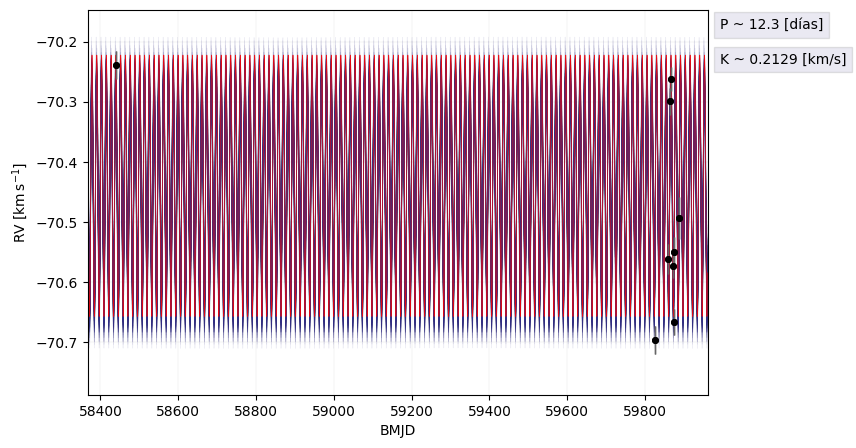

In [31]:
#fig = plt.figure(figsize=(8,10))
fig = plt.figure(figsize=(8,5))

gs = fig.add_gridspec(1, 1, hspace=0.02, wspace=0.05)
(ax1) = gs.subplots(sharex=True)


#_ = tj.plot_rv_curves(samples,data=data,plot_kwargs=dict(color="#f7b48f"),data_plot_kwargs=dict(color="k"),relative_to_t_ref=False,ax=ax1, add_labels=True)
_ = tj.plot_rv_curves(Filtrado,data=data,plot_kwargs=dict(color="#322e82"),data_plot_kwargs=dict(color="k"),relative_to_t_ref=False,ax=ax1, add_labels=True)
_ = tj.plot_rv_curves(Filtrado.median_period(),data=data,plot_kwargs=dict(color="r"),data_plot_kwargs=dict(color="k"),relative_to_t_ref=False,ax=ax1, add_labels=True)

plt.text(1.02, 0.95, f'P ~ {round(x_max_density, 4)} [días]', transform = ax1.transAxes,bbox = {'facecolor': "#322e82", 'alpha': 0.1, 'pad': 4})
plt.text(1.02, 0.86, f'K ~ {round(y_max_density, 4)} [km/s]', transform = ax1.transAxes,bbox = {'facecolor': "#322e82", 'alpha': 0.1, 'pad': 4})

for ax in fig.get_axes():
    ax.label_outer()
    ax.grid(linestyle='-', linewidth=0.1)

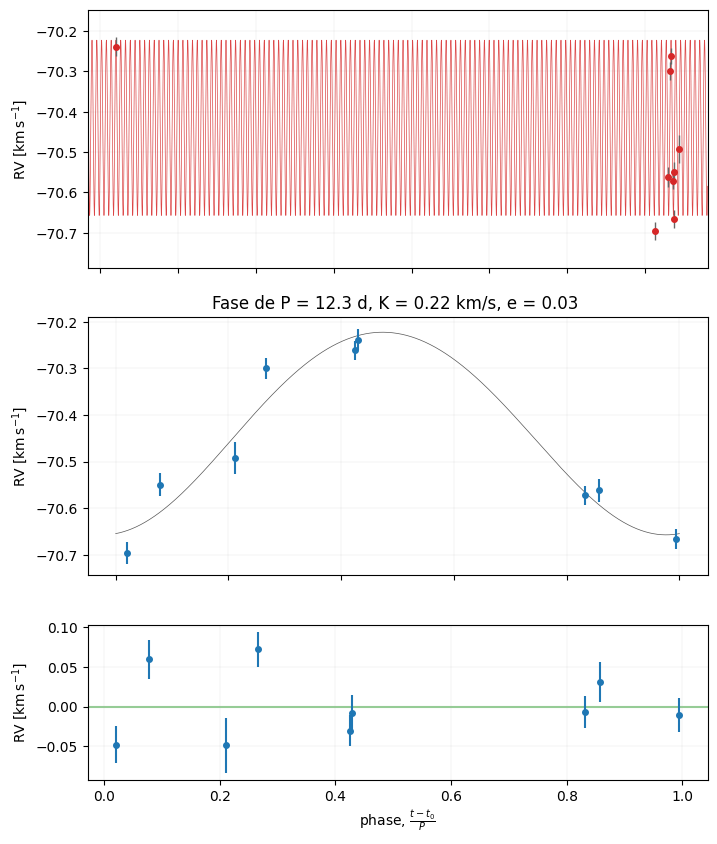

In [32]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10), gridspec_kw={"height_ratios": (3, 3, 1.8), 'hspace': (0.22)})

ax[1].set_title(f"Fase de P = {round(float(Filtrado.median_period()['P'].value),2)} d, K = {round(float(Filtrado.median_period()['K'].value),2)} km/s, e = {round(float(Filtrado.median_period()['e'].value),2)} ")

_ = tj.plot_rv_curves(Filtrado.median_period(),data=data,plot_kwargs=dict(color="tab:red"),data_plot_kwargs=dict(color="tab:red"),relative_to_t_ref=False,ax=ax[0])
_ = tj.plot_phase_fold(Filtrado.median_period(),data=data,ax=ax[1],remove_trend = False)
_ = tj.plot_phase_fold(Filtrado.median_period(), data, ax=ax[2], residual=True)

ax[2].axhline(0, zorder=-10, color="tab:green", alpha=0.5)
#ax[1].set_ylim(-0.5, 0.5)
for ax in fig.get_axes():
    ax.label_outer()
    ax.grid(linestyle='-', linewidth=0.1)

#### Función de masa binaria
$$f(M) = \frac{M_2 \sin^3(i)}{(1+q)^2} = \frac{PK_1^3 (1-e^2)^{3/2}}{2\pi G}$$

Con $q = \frac{M_1}{M_2}$

In [33]:
# En nuestro caso
P = x_max_density*u.d 
e = picos[3] 
K = y_max_density*1000*u.m*1/u.s 

In [34]:
print("P =",P)
print("e =",e)
print("K =",K)

P = 12.300005575833694 d
e = 0.1465044704730528
K = 212.8955800175093 m / s


In [35]:
def f(P,e,K):
    G = 6.67430e-11*(u.m)**3*1/u.kg * 1/u.s**2
    f = (P*K**3*(1-e**2)**(3/2))/(2*np.pi*G)
    f = f.cgs
    f = (f/(1.989e+33*u.g)*u.M_sun)
    return f

In [36]:
# Función de masa
f_value = f(P,e,K)
f_value

<Quantity 1.190047e-08 solMass>

In [37]:
M1 = 0.8*u.M_sun
sini =  1

In [38]:
# Ejemplo de uso
def resolver_ecuacion_cubica(a, b, c, d):
    coeficientes = [a, b, c, d]
    raices = np.roots(coeficientes)
    return raices
    
a = (sini)**3
b = -f_value.value
c = -2*M1.value*f_value.value
d = -M1.value**2*f_value.value

raices = resolver_ecuacion_cubica(a, b, c, d)
print("Las raíces de la ecuación son:", raices)

Las raíces de la ecuación son: [ 0.00197073+0.j         -0.00098536+0.00170111j -0.00098536-0.00170111j]


In [39]:
M2 = raices[0].real*u.M_sun
M_jupiter = 1.898e27*u.kg
print("La masa del objeto en M_Sun, M2 = ",M2)
print("La masa del objeto en kg, M2 = ",M2.to("kg"))
print("La masa del objeto en M_J, M2 = ",M2.to("M_jup"))
print("La masa del objeto en M_E, M2 = ",M2.to("M_earth"))

La masa del objeto en M_Sun, M2 =  0.0019707296482046775 solMass
La masa del objeto en kg, M2 =  3.918618284967478e+27 kg
La masa del objeto en M_J, M2 =  2.064468418178194 jupiterMass
La masa del objeto en M_E, M2 =  656.1467078146043 earthMass


Las **enanas marrones** son objetos subestelares que tienen más masa que los planetas gigantes gaseosos más grandes , pero menos que las estrellas menos masivas de la secuencia principal. Su masa es aproximadamente de $13 - 80$ veces la de Júpiter ( $M_J$ ) 

In [63]:
P_all = Filtrado["P"]
e_all = Filtrado["e"]
K_all = Filtrado["K"].to(u.m/u.s)

# Función de masa
f_value_all = f(P_all,e_all,K_all)
f_value_all

<Quantity [1.14329414e-08, 1.20471036e-08, 1.30293987e-08, 1.12285889e-08,
           1.02732930e-08, 1.10109808e-08, 1.21266017e-08, 1.27525286e-08,
           1.08427813e-08, 1.15906711e-08, 1.16549015e-08, 1.14777403e-08,
           1.10345364e-08, 9.54887584e-09, 1.17396678e-08, 1.07689197e-08,
           1.31045831e-08, 1.29534163e-08, 9.61447747e-09, 1.28525629e-08,
           1.13546938e-08, 1.21985813e-08, 1.20172696e-08, 1.09887426e-08,
           1.18288978e-08, 1.26332154e-08, 1.05068336e-08, 9.84622785e-09,
           1.30239307e-08, 1.32221551e-08, 1.04288576e-08, 1.08520496e-08,
           1.23507661e-08, 1.27619235e-08, 1.21516823e-08, 1.07673930e-08,
           1.00684914e-08, 1.11799218e-08, 1.30563904e-08, 1.08437455e-08,
           1.03161264e-08, 1.05634996e-08, 1.25602718e-08, 1.28356067e-08,
           1.09921679e-08, 1.03040546e-08, 1.19746732e-08, 1.26544469e-08,
           1.18304531e-08, 1.24334287e-08, 1.29198708e-08, 1.24122475e-08,
           1.07929336e-08

In [64]:
a_all = [(sini)**3]*len(f_value_all.value)
b_all = -f_value_all.value
c_all = -2*M1.value*f_value_all.value
d_all = -M1.value**2*f_value_all.value

raices_all = []
M2_all = []
for i in np.arange(len(f_value_all)):
    raices_all = (resolver_ecuacion_cubica(a_all[i], b_all[i], c_all[i], d_all[i]))
    M2_all.append(((raices_all[0].real*u.M_sun).to("M_jup")).value)

In [65]:
P31_full = samples[samples["K"].value<=30]

P_all_full = samples["P"]
e_all_full = samples["e"]
K_all_full = samples["K"].to(u.m/u.s)

# Función de masa
f_value_all_full = f(P_all_full,e_all_full,K_all_full)
f_value_all_full

<Quantity [1.40107602e-08, 1.48462402e-08, 1.46131211e-08, 1.14329414e-08,
           9.23250515e-09, 1.23046794e-08, 1.66258302e-08, 1.20471036e-08,
           1.05957827e-08, 1.51434922e-08, 1.43263415e-08, 1.27610037e-08,
           1.10043245e-08, 1.03928413e-08, 1.41398714e-08, 1.66226171e-08,
           1.35071125e-08, 1.30293987e-08, 1.54840905e-08, 8.78892319e-09,
           1.33740813e-08, 1.27382366e-08, 1.30353231e-08, 1.57252627e-08,
           1.11000719e-08, 1.01868468e-08, 1.08942265e-08, 1.32037238e-08,
           1.69026015e-08, 1.12285889e-08, 9.36829720e-09, 1.20858601e-08,
           1.48140113e-08, 1.21210425e-08, 1.02732930e-08, 1.23584149e-08,
           1.64722364e-08, 1.18043217e-08, 1.45074043e-08, 1.32075701e-08,
           1.29014813e-08, 1.63013392e-08, 1.41252086e-08, 1.18651640e-08,
           1.09686547e-08, 1.45312896e-08, 1.35994513e-08, 1.33267396e-08,
           1.11755044e-08, 1.06122027e-08, 1.10109808e-08, 1.21266017e-08,
           1.01514300e-08

In [66]:
a_all_full = [(sini)**3]*len(f_value_all_full.value)
b_all_full = -f_value_all_full.value
c_all_full = -2*M1.value*f_value_all_full.value
d_all_full = -M1.value**2*f_value_all_full.value

raices_all_full = []
M2_all_full = []
for i in np.arange(len(f_value_all_full)):
    raices_all_full = (resolver_ecuacion_cubica(a_all_full[i], b_all_full[i], c_all_full[i], d_all_full[i]))
    M2_all_full.append(((raices_all_full[0].real*u.M_sun).to("M_jup")).value)

El pico más alto de la distribución está en: 2.001110842065883


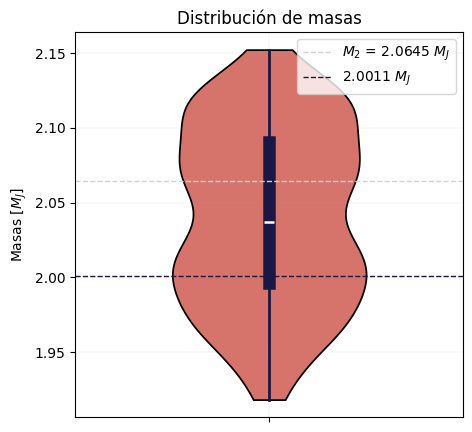

In [67]:
plt.figure(figsize=(5,5))
plt.title("Distribución de masas")


sns.violinplot(y = abs(np.array(M2_all)),inner_kws=dict(box_width=9, whis_width=2, color="#191743"),
               color = "#e3685c",saturation=0.8, fill=True, inner='box', split=False, width=0.5,
               dodge='auto', gap=0,density_norm='area',common_norm=False, bw_adjust=0.85,
              linecolor='k', cut=0, gridsize=250, native_scale=False)

# Calcula la densidad de la distribución
density = gaussian_kde(M2_all)

# Encuentra el rango de valores en el eje y
y_values = np.linspace(min(M2_all), max(M2_all), 1000)

# Evalúa la densidad en el rango de valores en el eje y
density_values = density(y_values)

# Encuentra el índice del máximo valor de densidad
peak_index = np.argmax(density_values)

# Encuentra el valor en el eje y correspondiente al pico
peak_value = y_values[peak_index]

print("El pico más alto de la distribución está en:", peak_value)

plt.axhline(y=M2.to("M_jup").value, color='#D0D3D4', linestyle='--',linewidth = 1, label = f'$M_2$ = { round(M2.to("M_jup").value,4)} $M_J$')
plt.axhline(y=peak_value, color='#191743', linestyle='--',linewidth = 1, label = f'{ round(peak_value,4)} $M_J$')

plt.ylabel("Masas [$M_J$]")
plt.legend()
plt.grid(linestyle='-', linewidth=0.1)
plt.show()

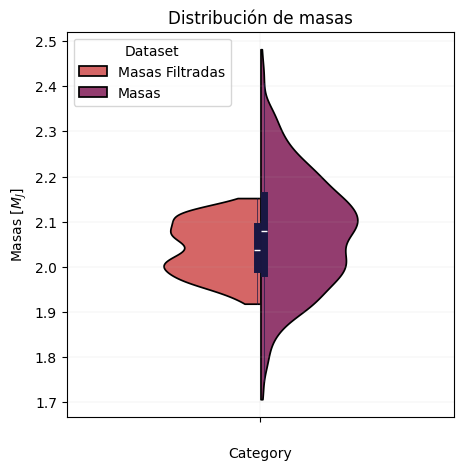

In [68]:
# Crear un DataFrame con las dos listas de datos
plt.figure(figsize=(5,5))
plt.title("Distribución de masas")

data = pd.DataFrame({
    'Value': M2_all + M2_all_full,
    'Dataset': ['Masas Filtradas'] * len(M2_all) + ['Masas'] * len(M2_all_full),
    'Category': ['  '] * len(M2_all) + ['  '] * len(M2_all_full)
})

# Crear el diagrama de violín con split=True usando la columna 'Category' para dividir los lados
sns.violinplot(x='Category', y='Value', hue='Dataset', data=data,inner_kws=dict(box_width=5, whis_width=0.5, color="#191743"),
               saturation=0.85, fill=True, inner='box', split=True, width=0.5,
               dodge='auto', gap=0,density_norm='area',common_norm=False, bw_adjust=0.85,
              linecolor='k', cut=0, gridsize=250, native_scale=False, palette = "flare")

# Ajustar el gráfico para que se vea mejor
plt.legend(loc='upper left',title='Dataset')
plt.ylabel("Masas [$M_J$]")
plt.grid(linestyle='-', linewidth=0.1)
# Mostrar el gráfico
plt.show()

### Estimación de la masa

In [134]:
B = 12.360 
V = 11.400
B_V = B-V
B_V

0.9599999999999991

#### Magnitud absoluta:

$$M = m - 5(log_{10}(d_{pc})-1)$$

In [135]:
m_V = V
d = np.mean([1293.810,1406.272,1307.8734,1138.96]) # Distancias encontradas en Simbad en pc
M=m_V-5*(np.log10(d)-1)
M

0.8525648076515715

#### Luminosidad

$$M = M_{\odot} - 2.5 \log_{10}\left(\frac{L}{L_{\odot}}\right)$$

$$L = 10^{-\frac{M-M_\odot}{2.5}}L_{\odot}$$

In [136]:
L=10**(-(M-4.83)/2.5)
L

38.9918711713353

In [137]:
masa = L**(1/3)
masa

3.3909758148752305